# Ensemble learning using random forest and linear (Ridge) regression
Reference: Coursera "Advanced machine learning" from HSE assignment "1C company"

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pickle

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

import GPy, GPyOpt
from GPyOpt.methods import BayesianOptimization

for p in [pd, np, sns, sklearn]:
    print (p.__name__, p.__version__)

pandas 0.25.1
numpy 1.16.5
seaborn 0.9.0
sklearn 0.21.3


In [2]:
# load dataset
df = pd.read_csv('glass.csv')
print(df.shape)
df.head()

(214, 11)


,Id number,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type of glass
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
df_test = df.drop(df.columns[[0, 10]], axis=1)
print(df_test.shape)
df_test.head()

(214, 9)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [4]:
X = df_test.iloc[:, 1:]
y = df_test.iloc[:, :1]

In [5]:
print(X.shape)
X.head()

(214, 8)


,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [6]:
print(y.shape)
y.head()

(214, 1)


,RI
0,1.52101
1,1.51761
2,1.51618
3,1.51766
4,1.51742


In [7]:
# Load model - random forest
with open('best_RF_sklearn.pickle', mode='rb') as f:
    best_rfr = pickle.load(f)

In [8]:
# Load models - Ridge
with open('best_Ridge_sklearn.pickle', mode='rb') as f:
    best_rgr = pickle.load(f)

In [9]:
# Check predictions by 2 models
pred_rfr = best_rfr.predict(X).reshape(-1, 1)
pred_rgr = best_rgr.predict(X)

print(pred_rfr[:5])
print(pred_rgr[:5])

[[1.52053058]
 [1.51755252]
 [1.51634003]
 [1.51787683]
 [1.51752972]]
[[1.52002012]
 [1.51663008]
 [1.51602959]
 [1.51764536]
 [1.5167603 ]]


In [10]:
# Check R2 scores by 2 models
print('R2 score random forest = ', r2_score(y, pred_rfr))
print('R2 score Ridge         = ', r2_score(y, pred_rgr))

R2 score random forest =  0.9364191811871309
R2 score Ridge         =  0.8887624427238439


### Concatenate test predictions to get test meta-features

In [11]:
# Concatnate 2 predictions
X_train_level2 = np.c_[pred_rfr, pred_rgr] 

print(X_train_level2.shape)
X_train_level2[:5]

(214, 2)


array([[1.52053058, 1.52002012],
       [1.51755252, 1.51663008],
       [1.51634003, 1.51602959],
       [1.51787683, 1.51764536],
       [1.51752972, 1.5167603 ]])

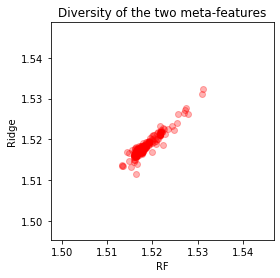

In [12]:
# Check diversity
plt.figure(figsize = (4, 4))
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1], marker = 'o', c = 'r', alpha = 0.3)
plt.title('Diversity of the two meta-features')
plt.xlabel('RF')
plt.ylabel('Ridge')
plt.show()

### Ensembling
Use simple linear convex mix:
$$
𝑚𝑖𝑥 = 𝛼⋅RF prediction + (1 − 𝛼)⋅Ridge prediction
$$

In [13]:
# Find alpha
alphas_to_try = np.linspace(0, 1, 1001)

best_alpha = 0
r2_train_simple_mix = 0

for alpha in alphas_to_try :
    mix = alpha * X_train_level2[:, 0] + (1 - alpha) * X_train_level2[:, 1]
    r2 = r2_score(y, mix)
    
    if r2 > r2_train_simple_mix :
        best_alpha = alpha
        r2_train_simple_mix = r2

print('Best alpha = ', best_alpha)

Best alpha =  0.802


In [14]:
# Make the level2 target
y_train_level2 = best_alpha * X_train_level2[:, 0] + (1 - best_alpha) * X_train_level2[:, 1]

In [15]:
y_train_level2[:5]

array([1.52042951, 1.51736988, 1.51627856, 1.517831  , 1.51737738])

### Stacking

In [16]:
# Train the new RF regression using the level2 target

bounds_rfr = [
    {'name': 'n_estimators', 'type': 'discrete', 'domain': (5, 500)},
    {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 100)},
    {'name': 'min_sample_split', 'type': 'discrete', 'domain': (2, 10)},
    {'name': 'min_samples_leaf', 'type': 'discrete', 'domain': (1, 5)}
]

# Optimization objective function

def rmse_rfr(*args):
    params = args[0]
    
    rfr = RandomForestRegressor(n_estimators = int(params[0][0]),
                                max_depth = int(params[0][1]),
                                min_samples_split = int(params[0][2]),
                                min_samples_leaf = int(params[0][3]),
                                bootstrap = True,
                                random_state = 0,
                                criterion = 'mse')
                
    rfr.fit(X_train, y_train)
    
    pred_rfr = rfr.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(pred_rfr, y_test))
    
    return RMSE

In [17]:
X_train, y_train = X, y_train_level2
X_test, y_test = X, y

In [18]:
%%time

optimizer = BayesianOptimization(f = rmse_rfr, domain = bounds_rfr)
optimizer.run_optimization(max_iter = 50)

Wall time: 8.11 s


In [19]:
optimizer.x_opt

array([500., 100.,   2.,   1.])

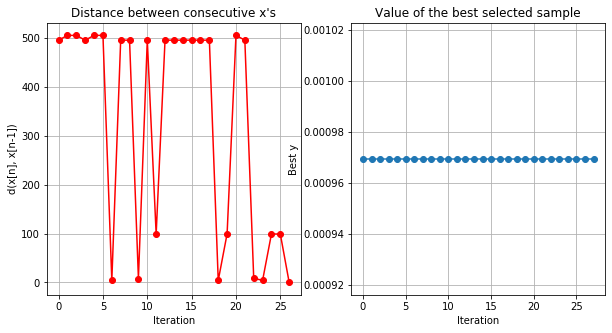

In [20]:
optimizer.plot_convergence()

### Check model performance by CV

R2 =   0.9677


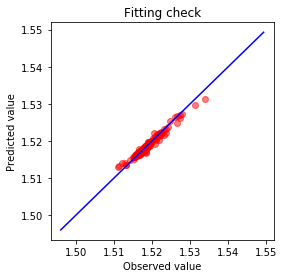

In [21]:
# Use all data
X_train, y_train = X, y

rfr_level2_model = RandomForestRegressor(n_estimators = int(optimizer.x_opt[0]),
                                         max_depth = int(optimizer.x_opt[1]),
                                         min_samples_split = int(optimizer.x_opt[2]),
                                         min_samples_leaf = int(optimizer.x_opt[3]),
                                         bootstrap = True,
                                         random_state = 0,
                                         criterion = 'mse')

rfr_level2_model.fit(X_train, y_train)
y_pred = rfr_level2_model.predict(X_train)

print('R2 = ', ' {:.4}'.format(r2_score(y, y_pred)))

plt.figure(figsize = [4, 4])
slp_1_begin = 0.99 * y.min()
slp_1_end   = 1.01 * y.max()

plt.scatter(y, y_pred, c = 'r', alpha = 0.5)
plt.plot([slp_1_begin, slp_1_end], [slp_1_begin, slp_1_end], c = 'b')
plt.title('Fitting check')
plt.xlabel('Observed value')
plt.ylabel('Predicted value')
plt.show()

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import (KFold, ShuffleSplit)
split_num = 5

cv_KF = KFold(n_splits = split_num, shuffle = True, random_state = 0)

print('Check best model perfromance in the folds')
for train_index, test_index in cv_KF.split(X):
    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
    y_pred = rfr_level2_model.predict(X_test)
    R2_reg = r2_score(y_test, y_pred)
    print(' {:.4}'.format(R2_reg))

Check best model perfromance in the folds
 0.9752
 0.9665
 0.9548
 0.9592
 0.9747


### Try another regressor

In [23]:
# Train the new XGBoost regression using the level2 target
import xgboost as xgb

bounds_xgr = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
    {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
    {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
    {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
    {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}
]

# Optimization objective function

def rmse_xgr(*args):
    params = args[0]
    
    xgr = xgb.XGBRegressor(learning_rate = params[0][0],
                           gamma = int(params[0][1]),
                           max_depth = int(params[0][2]),
                           n_estimators = int(params[0][3]),
                           min_child_weight = params[0][4],
                           bootstrap = True,
                           random_state = 0,
                           silent = True)
                
    xgr.fit(X_train, y_train)
    
    pred_xgr = xgr.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(pred_xgr, y_test))
    
    return RMSE

In [24]:
X_train, y_train = X, y_train_level2
X_test, y_test = X, y

In [25]:
%%time

optimizer = BayesianOptimization(f = rmse_xgr, domain = bounds_xgr)
optimizer.run_optimization(max_iter = 50)

Wall time: 18 s


In [26]:
optimizer.x_opt

array([1.00000000e+00, 1.91071958e-01, 5.00000000e+01, 3.00000000e+02,
       1.00000000e+01])

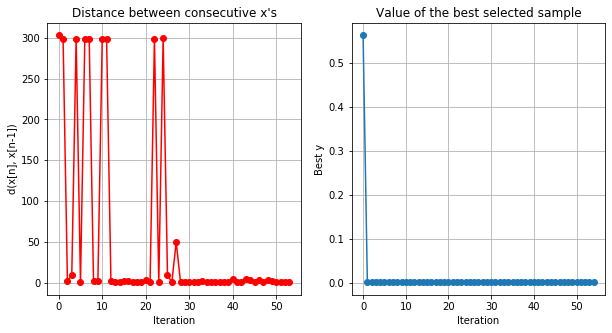

In [27]:
optimizer.plot_convergence()

### Check model performance by CV again

R2 =   0.9575


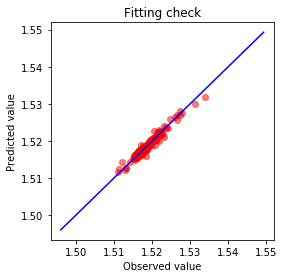

In [28]:
# Use all data
X_train, y_train = X, y

xgr_best = xgb.XGBRegressor(learning_rate = optimizer.x_opt[0],
                            gamma = int(optimizer.x_opt[1]),
                            max_depth = int(optimizer.x_opt[2]),
                            n_estimators = int(optimizer.x_opt[3]),
                            min_child_weight = optimizer.x_opt[4],
                            bootstrap = True,
                            random_state = 0,
                            silent = True)

xgr_best.fit(X_train, y_train)
y_pred = xgr_best.predict(X_train)

print('R2 = ', ' {:.4}'.format(r2_score(y, y_pred)))

plt.figure(figsize = [4, 4])
slp_1_begin = 0.99 * y.min()
slp_1_end   = 1.01 * y.max()

plt.scatter(y, y_pred, c = 'r', alpha = 0.5)
plt.plot([slp_1_begin, slp_1_end], [slp_1_begin, slp_1_end], c = 'b')
plt.title('Fitting check')
plt.xlabel('Observed value')
plt.ylabel('Predicted value')
plt.show()

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import (KFold, ShuffleSplit)
split_num = 5

cv_KF = KFold(n_splits = split_num, shuffle = True, random_state = 0)

print('Check best model perfromance in the folds')
for train_index, test_index in cv_KF.split(X):
    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
    y_pred = xgr_best.predict(X_test)
    R2_reg = r2_score(y_test, y_pred)
    print(' {:.4}'.format(R2_reg))

Check best model perfromance in the folds
 0.9839
 0.9625
 0.8977
 0.9376
 0.9717
